In [1]:
# pip install --upgrade tensorflow

In [2]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.optimizers import Adam

import tensorflow.keras.backend as K

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.initializers import he_uniform

from tqdm import tqdm



print(tf.__version__)

2.5.0-dev20200628


#### Load, convert and check data

In [3]:
# Read the data
# csv_train_file = pd.read_csv('./siim-isic-melanoma-classification/train.csv')
# csv_test_file = pd.read_csv('./siim-isic-melanoma-classification/test.csv')

# Pre-processed data files
X_train_load = pd.read_csv('./cleaned_csvs/train_pp.csv')
X_test_load = pd.read_csv('./cleaned_csvs/test_pp.csv')

X_train_pp = X_train_load.copy()
X_test_pp = X_test_load.copy()

# Drop the image names from the tabular data
X_train_pp.drop(['image_name'], axis=1, inplace=True)
X_test_pp.drop(['image_name'], axis=1, inplace=True)

# Separate target from predictors
y_train = X_train_pp.target
X_train_pp.drop(['target'], axis=1, inplace=True)

In [4]:
print(f'Number of Training Examples = {X_train_pp.shape[0]}')
print(f'Number of Test Examples = {X_test_pp.shape[0]}\n')

print("X_train_pp.shape:", X_train_pp.shape)
print("X_test_pp.shape:", X_test_pp.shape)
print("y_train.shape:", y_train.shape)

Number of Training Examples = 33126
Number of Test Examples = 10982

X_train_pp.shape: (33126, 13)
X_test_pp.shape: (10982, 13)
y_train.shape: (33126,)


In [5]:
display(X_train_pp.head(10))

,age_approx,age_id_min,age_id_max,sex_female,sex_male,sex_missing_value,anatom_site_general_challenge_head/neck,anatom_site_general_challenge_lower extremity,anatom_site_general_challenge_missing_value,anatom_site_general_challenge_oral/genital,anatom_site_general_challenge_palms/soles,anatom_site_general_challenge_torso,anatom_site_general_challenge_upper extremity
0,-0.259359,-0.093567,-0.422722,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.259359,-0.093567,-0.422722,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.084646,0.239713,0.280969,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-0.259359,-0.426847,-0.422722,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.428651,0.572993,0.280969,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,-0.603364,-0.426847,-0.774568,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,-1.635380,-1.426688,-1.478259,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,-0.947369,-0.760128,-0.774568,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,-1.291374,-1.093408,-1.478259,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,0.084646,0.239713,-0.070877,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


#### Tabular Data

In [6]:
# Convert training and test tabular data to numpy arrays
X_train_pp_np = np.array(X_train_pp, dtype="float32")
X_test_pp_np = np.array(X_test_pp, dtype="float32")
targets = np.array(y_train, dtype="uint8")

In [7]:
print("X_train_pp_np.shape:", X_train_pp_np.shape)
print("X_test_pp_np.shape:", X_test_pp_np.shape)
print("targets.shape:", targets.shape)

X_train_pp_np.shape: (33126, 13)
X_test_pp_np.shape: (10982, 13)
targets.shape: (33126,)


#### Build The Tabular Data ANN Model

In [8]:
# Prepare Validation Set (Using 20% held back for validation)
num_val_samples = int(len(X_train_pp_np) * 0.20)
train_features = X_train_pp_np[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_features = X_train_pp_np[-num_val_samples:]
val_targets = targets[-num_val_samples:]

print("Number of training samples:", len(train_features))
print("Number of validation samples:", len(val_features))
print("Number of training targets:", len(train_targets))
print("Number of validation targets:", len(val_targets))

Number of training samples: 26501
Number of validation samples: 6625
Number of training targets: 26501
Number of validation targets: 6625


In [9]:
# Analyze class imbalance in the targets
counts = np.bincount(train_targets[:])
print(
    "Number of positive samples in training data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(train_targets)
    )
)

weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]

Number of positive samples in training data: 470 (1.77% of total)


In [10]:
# Custom loss function

def focal_loss(y_true, y_pred):
    gamma = 2.0
    alpha = 0.25
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))

In [11]:
# Build a binary classification model
def build_model():

    rki = he_uniform(seed=1)    
    shape=(train_features.shape[-1],)

    ann_model = keras.Sequential(
        [
            keras.layers.Dense(256, activation="relu", input_shape=shape, kernel_initializer=rki),
            keras.layers.Dropout(0.4),
            keras.layers.BatchNormalization(),
            
            keras.layers.Dense(256, activation="relu", kernel_initializer=rki),
            keras.layers.Dropout(0.4),
            keras.layers.BatchNormalization(),
            
            keras.layers.Dense(1, activation="sigmoid"),
        ]
    )
    ann_model.summary()

    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    #loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05) 
    metrics = [keras.metrics.AUC(name="auc")]
    
    ann_model.compile(
        optimizer=opt, loss=[focal_loss], metrics=metrics
    )
    
    return ann_model

In [12]:
# Train the model with class_weight argument

ann_model = build_model()

ann_filepath = './trained_weights/ann/'

callbacks = [ModelCheckpoint(ann_filepath+"identification_model_at_epoch_best.h5", save_best_only=True, verbose=1)]
class_weight = {0: weight_for_0, 1: weight_for_1}

history_ann = ann_model.fit(
    train_features,
    train_targets,
    batch_size=512,
    epochs=200,
    verbose=2,
    callbacks=callbacks,
    validation_data=(val_features, val_targets),
    class_weight=class_weight,
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               3584      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2

Epoch 32/200

Epoch 00032: val_loss did not improve from 5.42874
52/52 - 0s - loss: 7.5817e-04 - auc: 0.4825 - val_loss: 5.4302 - val_auc: 0.3984
Epoch 33/200

Epoch 00033: val_loss improved from 5.42874 to 5.14220, saving model to ./trained_weights/ann/identification_model_at_epoch_best.h5
52/52 - 0s - loss: 7.3344e-04 - auc: 0.4900 - val_loss: 5.1422 - val_auc: 0.4246
Epoch 34/200

Epoch 00034: val_loss improved from 5.14220 to 5.13083, saving model to ./trained_weights/ann/identification_model_at_epoch_best.h5
52/52 - 0s - loss: 7.0918e-04 - auc: 0.4982 - val_loss: 5.1308 - val_auc: 0.4213
Epoch 35/200

Epoch 00035: val_loss improved from 5.13083 to 5.02648, saving model to ./trained_weights/ann/identification_model_at_epoch_best.h5
52/52 - 0s - loss: 6.9434e-04 - auc: 0.4803 - val_loss: 5.0265 - val_auc: 0.4218
Epoch 36/200

Epoch 00036: val_loss improved from 5.02648 to 4.93148, saving model to ./trained_weights/ann/identification_model_at_epoch_best.h5
52/52 - 0s - loss: 6.8418e-

Epoch 78/200

Epoch 00078: val_loss did not improve from 4.23469
52/52 - 0s - loss: 4.5422e-04 - auc: 0.5501 - val_loss: 4.2794 - val_auc: 0.6605
Epoch 79/200

Epoch 00079: val_loss did not improve from 4.23469
52/52 - 0s - loss: 4.3854e-04 - auc: 0.5747 - val_loss: 4.2366 - val_auc: 0.6815
Epoch 80/200

Epoch 00080: val_loss improved from 4.23469 to 4.22102, saving model to ./trained_weights/ann/identification_model_at_epoch_best.h5
52/52 - 0s - loss: 4.3978e-04 - auc: 0.5724 - val_loss: 4.2210 - val_auc: 0.6876
Epoch 81/200

Epoch 00081: val_loss did not improve from 4.22102
52/52 - 0s - loss: 4.3989e-04 - auc: 0.5736 - val_loss: 4.2337 - val_auc: 0.6863
Epoch 82/200

Epoch 00082: val_loss did not improve from 4.22102
52/52 - 0s - loss: 4.3783e-04 - auc: 0.5673 - val_loss: 4.2340 - val_auc: 0.6815
Epoch 83/200

Epoch 00083: val_loss did not improve from 4.22102
52/52 - 0s - loss: 4.2630e-04 - auc: 0.5863 - val_loss: 4.2243 - val_auc: 0.6817
Epoch 84/200

Epoch 00084: val_loss did not

52/52 - 0s - loss: 3.7206e-04 - auc: 0.6490 - val_loss: 4.0606 - val_auc: 0.7259
Epoch 124/200

Epoch 00124: val_loss improved from 4.06062 to 4.05728, saving model to ./trained_weights/ann/identification_model_at_epoch_best.h5
52/52 - 0s - loss: 3.7534e-04 - auc: 0.6463 - val_loss: 4.0573 - val_auc: 0.7286
Epoch 125/200

Epoch 00125: val_loss did not improve from 4.05728
52/52 - 0s - loss: 3.6643e-04 - auc: 0.6456 - val_loss: 4.0588 - val_auc: 0.7255
Epoch 126/200

Epoch 00126: val_loss did not improve from 4.05728
52/52 - 0s - loss: 3.7476e-04 - auc: 0.6479 - val_loss: 4.0710 - val_auc: 0.7265
Epoch 127/200

Epoch 00127: val_loss did not improve from 4.05728
52/52 - 0s - loss: 3.7050e-04 - auc: 0.6433 - val_loss: 4.0769 - val_auc: 0.7272
Epoch 128/200

Epoch 00128: val_loss improved from 4.05728 to 4.05709, saving model to ./trained_weights/ann/identification_model_at_epoch_best.h5
52/52 - 0s - loss: 3.6961e-04 - auc: 0.6440 - val_loss: 4.0571 - val_auc: 0.7266
Epoch 129/200

Epoch 0

Epoch 175/200

Epoch 00175: val_loss did not improve from 4.03601
52/52 - 0s - loss: 3.3677e-04 - auc: 0.6767 - val_loss: 4.0424 - val_auc: 0.7259
Epoch 176/200

Epoch 00176: val_loss did not improve from 4.03601
52/52 - 0s - loss: 3.3938e-04 - auc: 0.6867 - val_loss: 4.0451 - val_auc: 0.7267
Epoch 177/200

Epoch 00177: val_loss did not improve from 4.03601
52/52 - 0s - loss: 3.4025e-04 - auc: 0.7012 - val_loss: 4.0403 - val_auc: 0.7253
Epoch 178/200

Epoch 00178: val_loss did not improve from 4.03601
52/52 - 0s - loss: 3.3801e-04 - auc: 0.6954 - val_loss: 4.0405 - val_auc: 0.7274
Epoch 179/200

Epoch 00179: val_loss improved from 4.03601 to 4.03257, saving model to ./trained_weights/ann/identification_model_at_epoch_best.h5
52/52 - 0s - loss: 3.5093e-04 - auc: 0.6840 - val_loss: 4.0326 - val_auc: 0.7285
Epoch 180/200

Epoch 00180: val_loss did not improve from 4.03257
52/52 - 0s - loss: 3.4129e-04 - auc: 0.6851 - val_loss: 4.0377 - val_auc: 0.7271
Epoch 181/200

Epoch 00181: val_loss 

In [13]:
# Determine AUC score
# Pick out the history data that we want
auc = history_ann.history['auc']
val_auc = history_ann.history['val_auc']
loss = history_ann.history['loss']
val_loss = history_ann.history['val_loss']
epochs = range(len(auc))

train_auc = auc[-1]
print("Final Train AUC: ",train_auc)

val_auc_final = val_auc[-1]
print("Final Validation AUC: ",val_auc_final)

Final Train AUC:  0.6783080101013184
Final Validation AUC:  0.7259105443954468


In [14]:
max_val_auc = max(val_auc)
opt_epoch = val_auc.index(max(val_auc))

print("The best Validation AUC score was: ", max_val_auc)
print("The Epoch at which this was achieved was: ", opt_epoch)

The best Validation AUC score was:  0.7305215001106262
The Epoch at which this was achieved was:  140


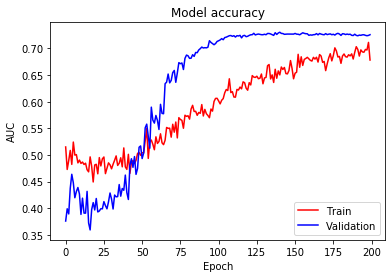

In [15]:
# Plot training & validation accuracy values
plt.plot(epochs, auc, 'r')
plt.plot(epochs, val_auc, 'b')
plt.title('Model accuracy')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [16]:
# Train the model on all data at the optimum epoch

K.clear_session()

# Train the model with class_weight argument
final_ann_model = build_model()

callbacks = []
class_weight = {0: weight_for_0, 1: weight_for_1}

history_ann = final_ann_model.fit(
    X_train_pp_np,
    targets,
    batch_size=512,
    epochs=opt_epoch,
    verbose=2,
    callbacks=callbacks,
    class_weight=class_weight,
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               3584      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2

Epoch 124/140
65/65 - 0s - loss: 3.4882e-04 - auc: 0.6679
Epoch 125/140
65/65 - 0s - loss: 3.4373e-04 - auc: 0.6814
Epoch 126/140
65/65 - 0s - loss: 3.5343e-04 - auc: 0.6739
Epoch 127/140
65/65 - 0s - loss: 3.4677e-04 - auc: 0.6849
Epoch 128/140
65/65 - 0s - loss: 3.4718e-04 - auc: 0.6786
Epoch 129/140
65/65 - 0s - loss: 3.4710e-04 - auc: 0.6796
Epoch 130/140
65/65 - 0s - loss: 3.4213e-04 - auc: 0.6826
Epoch 131/140
65/65 - 0s - loss: 3.4417e-04 - auc: 0.6821
Epoch 132/140
65/65 - 0s - loss: 3.3949e-04 - auc: 0.7027
Epoch 133/140
65/65 - 0s - loss: 3.4223e-04 - auc: 0.6875
Epoch 134/140
65/65 - 0s - loss: 3.4527e-04 - auc: 0.6737
Epoch 135/140
65/65 - 0s - loss: 3.4536e-04 - auc: 0.6810
Epoch 136/140
65/65 - 0s - loss: 3.4618e-04 - auc: 0.6919
Epoch 137/140
65/65 - 0s - loss: 3.4204e-04 - auc: 0.6915
Epoch 138/140
65/65 - 0s - loss: 3.4100e-04 - auc: 0.6829
Epoch 139/140
65/65 - 0s - loss: 3.4358e-04 - auc: 0.6856
Epoch 140/140
65/65 - 0s - loss: 3.4079e-04 - auc: 0.6851


In [17]:
# Load best weights
#ann_model.load_weights(ann_filepath+"identification_model_at_epoch_best.h5")

# Predict
preds_test = final_ann_model.predict(X_test_pp_np)

# Use .ravel() to flatten from 10982,1 to 10982,
output = pd.DataFrame({'image_name': X_test_load.image_name,
                       'target': preds_test.ravel()})
output.to_csv('./predictions/Keras_Tabular_Data_w_ClassWeight_and FocalLoss.csv', index=False)

In [18]:
preds_test

array([[0.17543074],
       [0.10978243],
       [0.10209477],
       ...,
       [0.12032273],
       [0.13315007],
       [0.06113657]], dtype=float32)

In [19]:
output.head()

,image_name,target
0,ISIC_0052060,0.175431
1,ISIC_0052349,0.109782
2,ISIC_0058510,0.102095
3,ISIC_0073313,0.097028
4,ISIC_0073502,0.144311
